In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
   width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

# Librerias y funciones 

In [28]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

<ipython-input-28-fd0b9af24538>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
import numpy as np
import os
# Para correr en hilos la evaluación este parametro aumenta significativamente la velocidad de evaluacion
os.environ['OMP_THREAD_LIMIT'] = '1'

In [3]:
import pytesseract
from matplotlib import pyplot as plt
import cv2

In [4]:
from pipeline_img import PipelineImg

In [5]:
import os
# https://stackoverflow.com/a/9728478
def list_files(startpath):
    files_path = []
    for root, dirs, files in os.walk(startpath):
        for indx in range(len(files)):
            files_path.append(root+"/"+files[indx])
    return list(filter(lambda el: el.endswith("JPG"), files_path))

In [6]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Cargando imagenes en la carpeta Ficheros

In [7]:
# Obtengo todas las imagenes que se descargaron
home_path = "/media/juan/jc/archivos_represion/Ficheros/"
imgs_paths = list_files(home_path)
print("{:,} imagenes encontradas dentro de la carpeta Ficheros".format(len(imgs_paths)))

18,008 imagenes encontradas dentro de la carpeta Ficheros



# Busqueda de hiperparametros
Algo que noté cuando realizaba la construcción de la clase <code>PipelineImg</code> es que los parametros para obtener una mejor lectura varian en gran medida de la resolución de la imagen y de la calidad de lo que rodea la hoja en la fotografía, controlo estos dos aspectos con el <b>resizing</b> y los <b>bordes</b>, en las siguientes celdas viene una busqueda de los "mejores" hiperparametros para las imagenes en función de la resolución de la imagen.




## Con 900px en height

-68.- Bl 24 actual "El Univ
ADIESTRAN CONUNISCAS EN ATO

 

nota
co involucia a oste cicconto,- La CCI do 'Garzón

“ díco desconocor cualquíor relación do osto clercl
“ 20 con ciombros del PCH, puos no tionon ligas co:
dicho Partico, y que de ser verdad lo dicho en
el periódico, so dostituir modiatarante de su
-actual puesto a este o..5……b:…o Exp.11-136-68.

. . H-96 1i-19.
9-700-68.-. So envió un boletín a diferantes dia-
' ríos capitalinos íntitulado "SAMUEL ADAME FLORES
: Ropto., da la CCT., en el Edo, de Cro.., "Ajeno to
! £almento en actos do ngitación".-Sec a…ao que al-
conprobar nsta Central su 1nocencia on los cargo


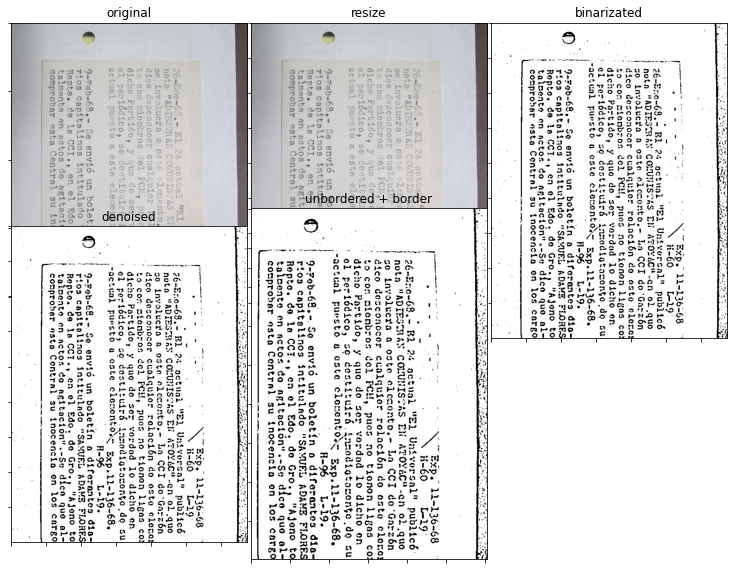

In [8]:
img = cv2.imread(imgs_paths[3])
pre_img = PipelineImg.do_full_pipeline(img, height=900,bordersize=15, auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 1 ")
text = pytesseract.image_to_string(pre_img, config=config)
print(text.strip())

## Con 1200px en height

“x

 

— e UN Exp. 11-136-68
… AE “H-60 L-19- —
26-Ene-68.- El 24 actual “El Universal" publicó
nota "ADIESTRAN COLMUNISTAS EN ATOYAC" en el que -
se involucfa a este elemento,- La CCI de Garzón -
dice desconocer cualquier relación de este"eleme)
+to con miembros del PCI, pues no tienen ligas col
dicho Partido, y que de ser verdad lo dicho en

el periódico, se destituirá inmediatamente de su
-actual puesto a mmcm_mwmawñfo.w Exp.11-136-68:

. — .. H=96  L=19e. .
9-Feb-68,- Se envió un boletín a diferantes dia-
rios capitalinos- intitulado "SAMUEL ADAME FLORES
Repte. de la CCI., en.el Edo, de Gro., "Ajeno to
talmente en actos de agitación".-Se dice que al-
comprobar esta Central su inocencia en los cargo


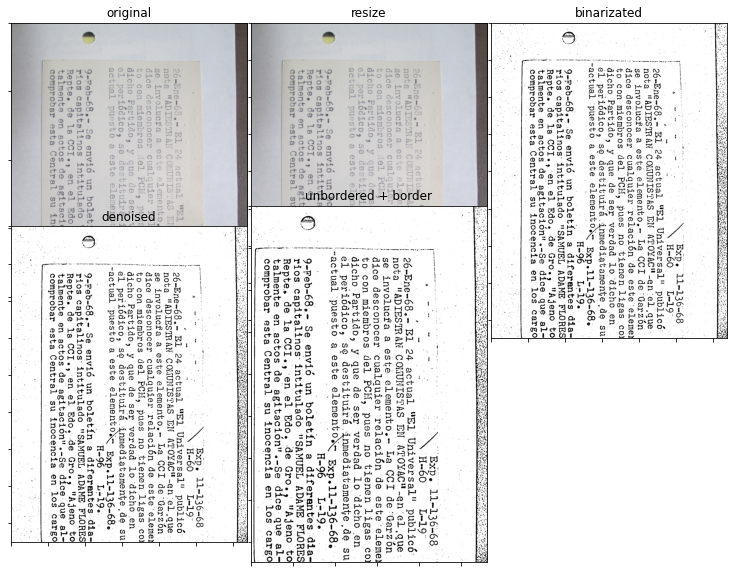

In [16]:
pre_img2 = PipelineImg.do_full_pipeline(img, height=1700, bordersize=15, auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 1 ")
text = pytesseract.image_to_string(pre_img2, config=config)
print(text.strip())

Use una forma algo primitiva de detectar el expediente: <code>s_exp = lambda txt: re.search("(\d{1,3})(-)(\d{1,3})(-)(\w{1,3})", txt) if txt is not None else None</code>, teniendo el texto generado podremos aplicar mejor tecnicas de RegEx.

## Busqueda de hiperparametros

In [17]:
from sklearn.model_selection import ParameterGrid
import random
random.seed(1234)
param_grid = {'path':random.sample(imgs_paths,500), 'sigma': [0.33, 0.01], 'pixels' : [900, 1100, 1200, 1300, 1700], "border":[15,20,25]}
grid = ParameterGrid(param_grid)


In [18]:
len(list(grid))

15000

In [9]:
len(list(grid))

8000

In [19]:
import re
is_exp = lambda txt: re.search("(\d{1,3})(-)(\d{1,3})(-)(\w{1,3})", txt) if txt is not None else None
is_date = lambda txt: re.search("(\d{2})-([a-zA-Z]{3})-(\d{2})", txt) if txt is not None else None

def get_evaluation(indx):
    print(".", end="")
    grd = grid[indx]
    path, sigma, pixels, border = grd["path"], grd["sigma"], grd["pixels"], grd["border"]
    img = cv2.imread(path)
    final_img = PipelineImg.do_full_pipeline(img, debug=False,bordersize=border, auto_canny_sigma=sigma, height=pixels)
    
    config=None
    if img.shape[0]> img.shape[1]:
        config = ("-l spa --psm 1")
    else:
        config = ("-l spa --psm 6 ")
    text = pytesseract.image_to_string(final_img, config=config)
    print("-", end="")
    
    return (path, *img.shape, sigma, pixels, border, 0 if is_exp(text) is None else 1, 0 if is_date(text) is None else 1)
    

In [20]:
#from 01:00 to
import multiprocessing as mp
print("Procesando con {} nucleos".format(mp.cpu_count()))
pool = mp.Pool(mp.cpu_count())
results = pool.map(get_evaluation,[ indx for indx in range(len(list(grid)))])
pool.close()

Procesando con 8 nucleos
........-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.--..-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.--..-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-

In [21]:
import pandas as pd
df = pd.DataFrame(results,columns=["path","shape_a","shape_b", "shape_c","sigma","pixels","border","is_exp","is_date"])
df.to_csv("data/hp_tunning_500_v2.csv", index=False)

In [18]:
df.head(2)

,path,shape_a,shape_b,shape_c,sigma,pixels,border,is_exp,is_date
0,/media/juan/jc/archivos_represion/Ficheros/UPC...,3456,4608,3,0.33,900,5,0,0
1,/media/juan/jc/archivos_represion/Ficheros/UPC...,3456,4608,3,0.33,1100,5,0,0


In [22]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('params').getOrCreate()

In [23]:
dataframe = spark.read.csv("data/hp_tunning_500_v2.csv", header=True)

In [24]:
from pyspark.sql import Window

### Los "mejores" parametros para cada resolución

In [25]:
wm = Window.partitionBy(F.col("shape_a"),F.col("shape_b")).orderBy(F.col("prop_exp").desc(), F.col("prop_date").desc())
dataframe.groupby(F.col("shape_a"),F.col("shape_b"), F.col("sigma"), F.col("pixels"), F.col("border")).agg(
(F.sum(F.col("is_exp"))/F.count("*")).alias("prop_exp"),
    (F.sum(F.col("is_date"))/F.count("*")).alias("prop_date"),
    F.count("*").alias("total")
).orderBy(F.col("prop_exp").desc()).withColumn("row_number", F.row_number().over(wm)).where(F.col("row_number")  == 1).show(truncate=False)

+-------+-------+-----+------+------+-------------------+--------------------+-----+----------+
|shape_a|shape_b|sigma|pixels|border|prop_exp           |prop_date           |total|row_number|
+-------+-------+-----+------+------+-------------------+--------------------+-----+----------+
|1728   |2304   |0.33 |1200  |15    |0.625              |0.07142857142857142 |56   |1         |
|2432   |4320   |0.01 |900   |20    |1.0                |0.6                 |5    |1         |
|3456   |4608   |0.01 |1300  |25    |0.55               |0.0875              |240  |1         |
|2304   |1728   |0.33 |1300  |20    |0.25               |0.041666666666666664|24   |1         |
|1944   |2592   |0.33 |1300  |15    |0.704225352112676  |0.056338028169014086|71   |1         |
|4608   |3456   |0.33 |1200  |15    |0.18840579710144928|0.043478260869565216|69   |1         |
|3264   |2448   |0.33 |1300  |20    |0.20833333333333334|0.08333333333333333 |24   |1         |
|2448   |3264   |0.33 |1200  |20    |0.8

In [27]:
"""configs = [
    {"h":1728, "w":2304 , "sigma":0.33, "pixels":1300    ,"border":10   },
    {"h":2432, "w":4320 , "sigma":0.33, "pixels":1100    ,"border":5   },
    {"h":3456, "w":4608 , "sigma":0.33, "pixels":1100    ,"border":5   },
    {"h":2304, "w":1728 , "sigma":0.33, "pixels":1300    ,"border":10  },
    {"h":1944, "w":2592 , "sigma":0.33, "pixels":1200    ,"border":10  },
    {"h":4608, "w":3456 , "sigma":0.33, "pixels":1300    ,"border":5   },
    {"h":3264, "w":2448 , "sigma":0.33, "pixels":1200    ,"border":5   },
    {"h":2448, "w":3264 , "sigma":0.33, "pixels":1200    ,"border":5   }]"""
configs = [{"h":1728, "w":2304, "sigma":0.33, "pixels":1200, "border":15},
{"h":2432, "w":4320, "sigma":0.01, "pixels":900, "border":20},
{"h":3456, "w":4608, "sigma":0.01, "pixels":1300, "border":25},
{"h":2304, "w":1728, "sigma":0.33, "pixels":1300, "border":20},
{"h":1944, "w":2592, "sigma":0.33, "pixels":1300, "border":15},
{"h":4608, "w":3456, "sigma":0.33, "pixels":1200, "border":15},
{"h":3264, "w":2448, "sigma":0.33, "pixels":1300, "border":20},
{"h":2448, "w":3264, "sigma":0.33, "pixels":1200, "border":20}]
def get_nearest_conf(shape):
    return min(configs,key=lambda cnf: np.sqrt(((cnf["h"]-shape[0])**2)+((cnf["w"]-shape[1])**2)))

In [28]:
get_nearest_conf((1920,1080 ))

{'h': 2304, 'w': 1728, 'sigma': 0.33, 'pixels': 1300, 'border': 20}

! CAVILA. JUAREZ Fausto -7- . — Exp-100-10-1-67: |
P D - H-264+- L2%, -
1. 26,-Juñ,-67.-Se- encuentra- confeso de los delitos
- de DIFAMACION, ASOCIGCION DELICTUOSA,-INJURNAS, í
f" DIFUSION DE IDEAS Y PLAXMES TENDIENTES A ALTERAR '
= EL.ORDEN Y LA PAZ DEL EDO., por lo que el 25 ac=
| tual-el Juez LIC, HUGO PEREZ BAUTISTA probable-
f nente. le: declare la formal prision, .
j _- . Exp-100-10-1=67, |
. H-271 L-24. !
: 27.-Jun,-67.-El dia 24 actual a las 14,00Hrs,: -
; el Lic. HUCO PEREZ-BAUTISTA Jugz Mixto de Primer,
! Instancia del Dto, Judicial de' Bravo, Dicto auto
i de Formal: prisjon en contra de ESTE ELEMENTO y :
!Í -otros con los que fue detenidos; por los delitos
- . “. Tul e . -


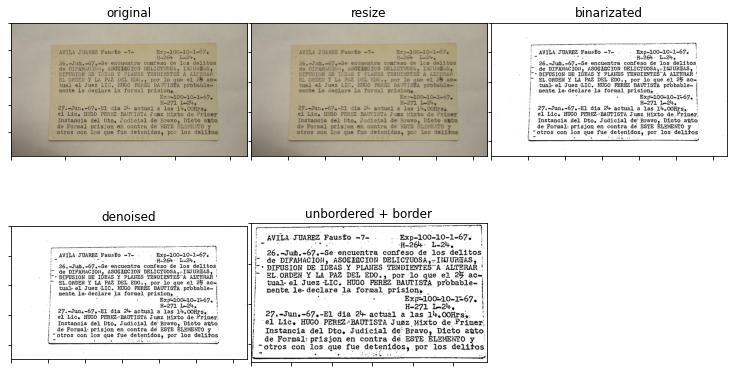

In [30]:
img = cv2.imread(imgs_paths[35])
conf = get_nearest_conf(img.shape)
pre_img = PipelineImg.do_full_pipeline(img, height=conf["pixels"],bordersize=conf["border"] ,auto_canny_sigma=0.33, debug=True)
config = ("-l spa --psm 6 ")
text = pytesseract.image_to_string(pre_img, config=config)
print(text.strip())

# Etiquetando todas las imagenes

In [8]:
configs = [{"h":1728, "w":2304, "sigma":0.33, "pixels":1200, "border":15},
{"h":2432, "w":4320, "sigma":0.01, "pixels":900, "border":20},
{"h":3456, "w":4608, "sigma":0.01, "pixels":1300, "border":25},
{"h":2304, "w":1728, "sigma":0.33, "pixels":1300, "border":20},
{"h":1944, "w":2592, "sigma":0.33, "pixels":1300, "border":15},
{"h":4608, "w":3456, "sigma":0.33, "pixels":1200, "border":15},
{"h":3264, "w":2448, "sigma":0.33, "pixels":1300, "border":20},
{"h":2448, "w":3264, "sigma":0.33, "pixels":1200, "border":20}]
def get_nearest_conf(shape):
    return min(configs,key=lambda cnf: np.sqrt(((cnf["h"]-shape[0])**2)+((cnf["w"]-shape[1])**2)))
def eval_img(path):
    img = cv2.imread(path)
    conf = get_nearest_conf(img.shape)
    pre_img = PipelineImg.do_full_pipeline(img, height=conf["pixels"],bordersize=conf["border"] ,auto_canny_sigma= conf["sigma"], debug=False)
    config=None
    if img.shape[0]> img.shape[1]:
        config = ("-l spa --psm 1")
    else:
        config = ("-l spa --psm 6 ")
    text_data = pytesseract.image_to_string(pre_img, config=config)
    print("-", end="")
    return (path, text_data)

In [9]:
%%time
import multiprocessing as mp
print("Procesando con {} nucleos".format(mp.cpu_count()))
pool = mp.Pool(mp.cpu_count())
results = pool.map(eval_img, imgs_paths)
pool.close()

Procesando con 8 nucleos
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
import pandas as pd
df = pd.DataFrame(results,columns=["path","text"])
df.to_csv("text/Archivos.csv", index=False)

In [11]:
df.head()

,path,text
0,/media/juan/jc/archivos_represion/Ficheros/ACN...,"ADAIÍ¿£L¿0I33“%?&1IBÍÍÍ""""”<E…-fó'o—10-1—67.5 T..."
1,/media/juan/jc/archivos_represion/Ficheros/ACN...,+ 26-4bril-71.-Con. motivo de la detención por...
2,/media/juan/jc/archivos_represion/Ficheros/ACN...,"Z — ADAME TLORES Samiel N EXp-100-10-1-67,\n-1..."
3,/media/juan/jc/archivos_represion/Ficheros/ACN...,\n\n \n\n—\n\n— - Ti N Expe 21-136-68\n\n.- ...
4,/media/juan/jc/archivos_represion/Ficheros/ACN...,"CESANTE r RN E AE E a A TI ea d\n.: N, “_,:'1 ..."


# Revision de salidas primer desarrollo

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', False)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('explotacion').getOrCreate()
#salida_dataframe.write.parquet("text/archivos")

In [3]:
salida_dataframe = spark.read.parquet("text/archivos")

In [4]:
match_regx5 = "((\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3}))"
match_regx4 = "((\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3}))"
match_regx3 = "((\d{1,3})(-|=|_|--|__|==|—)(\d{1,3})(-|=|_|--|__|==|—)(\d{1,3}))"
exp_dataframe = salida_dataframe.withColumn("exp5",
                            F.regexp_extract(F.col("text"), match_regx5,1)
                ).withColumn("exp4",
                            F.regexp_extract(F.col("text"), match_regx4,1)
                ).withColumn("exp3",
                            F.regexp_extract(F.col("text"), match_regx3,1)
                )

In [18]:
exp_dataframe.where((F.col("exp3") != "" ) & (F.col("exp4") == "" )).limit(3).toPandas()

,path,text,exp5,exp4,exp3
0,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6840.JPG,"\n\n \n\n—\n\n— - Ti N Expe 21-136-68\n\n.- - H-60 L-19-\n26-Enc-68:- El 24 actual ""“El Universal"" publicó\nnota ""ADIESTRAN COLUNISTAS Elí ATOYAC"" en'el que\nsa involucía a este elomento,- La CCI de ""Garzón\ndice desconocer cualquier relación de este-elene)\nto con miembros del PCi, pues no tienen lígas col\n\n_… dicho Partido, y que de ser verdad lo dicho en\n\n“ él periódico, sc destituirá inmediatamente de su\n-actual 'puesto a om:o.owmno=wavn Exp.11-136-68.\n\n_ | — H-9% L-19: .\n9-Feb-68.-. Se envió un boletín a diferantes diía-\nríos capitalinos” intitulado ""SAMUEL. ADAME FLORES\n- Repte. de la CCI., en el Edo, de Gro. , ""Ajeno to\n! talmente en actos de agítación"".-Se a…om que al-\n\ncomprobar esta Central su inocencia en los cargo\n\n|\n!\n\n \n\n \n",,,21-136-68
1,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Alvarado_Vazquez_Blanca_Luz/IMG_6849.JPG,"ALVARADO VAZQUEZ, Blancá Luz. Exp.. 11-169-70 —\n| o — H-10 L-21 ]\n28-Pic-70.- DOM: Tlacotal ""Z"" No, 2432 Col. R\n\n, D . » Ra-\nl mos Millán,- “1 25 actual visitó:en el'—?.f>enal a- ! |\n| DAMOSTENES ONOFRE VALDOVINOS,- — ., =\na Exp, 11-169-71 |\n_ — H-187 L-21 '\n.2-Ene-71,- El 31 de diciembro Áltino visitó en\ne l presidio a DENE TE:ES ONOTRE VALDOVINOS,\n» Exp. 11-169-71\n_ . | H-295. A\n| 5-Ene-71.- “1 3 actual visitó en el penal a -\n| DENOSTENES . ONÓFRE VALDOVINOS.- Exp-11-169-71.\n| D H-362 1-21. |\n| 20-ENE—Z1.-— 1 l'gmactual visitó en el penal a M£-:\n! 2O RENETO MENENDEZ RODRIGUEZ — |\n' . - - . - ]\n",,,11-169-70
2,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Alvarado_Vazquez_Blanca_Luz/IMG_6850.JPG,"E — Exp:11-169-71.\n: - H-348 L-22,\n. Eoo-NMar-71.-El 21 actual visitó en el penal a:\n'í — CONOFRE DEMOSTENES VALDESPINO,---"". -\nf . - - . - - .\ni ffº'j.*.'. * -\n",,,11-169-71


In [13]:
exp_dataframe.count()

18008

In [19]:
9011/18008

0.5003887161261662

In [12]:
exp_dataframe.where(F.col("exp3") != "").count()

9011

In [15]:
exp_dataframe.where(F.trim(F.col("exp3")) == "").count()

8997

In [16]:
exp_dataframe.where(F.col("exp4") != "" ).count()

4793

In [ ]:
exp_dataframe.where(F.col("exp3").isNotNull()).count()

In [24]:
exp_dataframe.where(F.col("path").like("%Agustin-36%")).toPandas()

,path,text,exp5,exp4,exp3
0,"/media/juan/jc/archivos_represion/Ficheros/Represores/Alanis_Fuentes_Agustin/76-12-02_a_78-01-13/De_76-12-02_a_78-01-13,_ALANIS_FUENTES,_Agustin-36-.JPG","Wºlf*?ur“%º,%á:; Stín.-Lic, .- - Pxn—lºº”l7£lg;_2 -\n3 M A e H27 DT\nA A AE A aa E n M 7|\n—| terrey,N:15 iNra AE evhocimiento de la intor-""\n—| vención que tuvo en ese “confideto.1a' Ped: , Obrera |—-\n— R- volúcioneri a*—PoStericrmente comiintcó a la. ci--\n—ttada -comisión. quepor ingtruccine s del tituler-de\n'_'?i'é.fíºsr Ía.,del Trabejo,se comunicó con-el C.Cobéer—y\n“:'Eíñadoif del Fdo.;de N.L: ,a quiensolicitó su-inter==--\n.vención pera solucioner este -asunto ,recomendándos —\n'Fg.e3»""q:ge retornarán a su lugar deorisen,— - Ne b\nEA TN Exp:40-73-73 —\nj a - _ .. | - N H..174 - I,._1º S\n'[9—-Ene—73_;'—'El' 5, del actl, -estuvo -yresente en la E E\n— ¡coneiliaciónéntre el Sindica y laCía. Hulera —--\n7—.,F_Eu,Zk8¿iá S..4e:5..en-donde. 1legaron' a varios acue rdó;an\n",,,40-73-73
1,"/media/juan/jc/archivos_represion/Ficheros/Represores/Alanis_Fuentes_Agustin/79-07-16_a_85-11-20/De_79-07-16_a_85-11-20,_ALANIS_FUENTES,_Agustin-36-.JPG","\n\nr\ne\n\n…O. anb m¿mvmumuumo eT ap. 0u=0.……=20.6…..u T2 eled mW:.F\nL C AICRT _ommou ÓdATOL OINOINV “opa Tap 10peurda\n“ 09' TS que K- “PepnTo-ejsa ap oATINDALa TAJOH o\nuD “seuosiad sel13o- u ©¿…3…w…ñm — UTS ..c……o……….asu…\n\n. T8-Aeu- TT - o N . - o\n\n— — ££0-9v0-S720 - .mu……-.m3 :\n\n- :UDTIIOS SOT ap eZ Ta mumao.…c.… “eTSTISAL ap saTtEl-\n\n…||o=mo solTOpeinoa.d ap ejtnsuo) A UQTORUIOJUI ap:\n\n…Hmcoammm UQTUNSY ET ap easnefo el oa…u.…moum,_omu,……\nII…|||MH©U oTqaed UES. IP co....um……noo m,m ua - .Xno.mom&mº\nu .3<……[¿. — , N\n— “e£0-970-070,. 7 * - qetgoe TO S7 TO |\n— eatutauo9 o:v.……¿u…umsb ap SuTeIVUS9 SBlOPRINIOId\n|l…x.l 0wu. mu.—swcoo A c0¿um:uou.c…… .39 .V…mco._m_om coHc:0m _\n\nd B aa A ¿t.)ÍL\n\n.. -r*r.-'w T\n\n \n\n \n\nHe\ni\n\n \n",,,0-970-070


In [22]:
exp_dataframe.where(F.col("exp4").like("%31%")).toPandas()

,path,text,exp5,exp4,exp3
0,"/media/juan/jc/archivos_represion/Ficheros/Carmelo_Cortes_Castro/Ficha_2/FAR,_concentrado_general-442-.JPG","TA A A D e ei p DI\n— ANR A REEO E VUN EA N EEO T MCO\nen NA ;:&3='Ej—;…—á …yw?v""éíí?n&í%??í%ng f N\ne TE RE A T A A EB E\nEa E E ENN TA 7 EA EA A ANENG AEE :! . PE\nSOO AA EE ENO E £ * EEO\nU lañancsnasaaérciaro oee eic\nS Ae N TNANO A ERP AA 1D EA d ANAN\nEE ANE N NA E\neA UN CORTES CASTRO Carmelo 19 — %O£:10-'-_1—66 A\nEA :I,'é N ENe lí-gg+ L22i — rirf*00\nA EE AE 287 Dic.-66.-El día 13 actual.a las 13.85 Hrs,- P-% 7 c\nf:1'¿3...""33“'Í1Í.;—_]?;f_v'_—*-?¿¡'¿?_:7íf.—_':'_—_j.¿.4':1""E fueron puestos en l1bertad los estudiantes Uni | i5 -C\nAE NAA á versitarios. VIRGILIO DE LA CRUZ HDEZ, MARIANO | -% E\nea en .i 8 - ""SOLIS LEYVA, ARNULFO MORALES CUEVAS CARLOS CAS|. t\nT e E- TREJON, BUSTÁMANTE CARNELO CORTES CÁSTRO, GABIN M n\nTE a E ru Í:»á ORGANISTA AGUILARy RICARDO COM:2 RADILLA, falf:c < U| +\nO E O tando unicanente PEDRO HEKCGUERA JIMENEZ, quien —'f.1]?;,; ' fí\nEA AN *se negb a firmar-un escrito que todos los estu |: ¡X —\neA N -A| diantes mencionados acordaron enviar. el día 12 | - ; (\nE AA ? actual al C.Juez Mixto de Lra, Instancía del Dtd. ""a —\nae Ta 4 - Judicial de Bravos,Gro, LIC. LEYVA Y CORDOBA, Ea\n— Í,f'í=€'*f,f"";—¡ff “n=ir 4144 poe consideratdo ofansivo hacia 61 $a que expre 1'.5.5¡ .\nTA T AREN ? sa que no ha cometido delito alguno. El escrito |« .\nAE 3 X _ dice lo siguiento: . — - . H\nEREA Í ON\nNE UN ""'º.55 NA R De ANAN A ANAN ACE %w% .\nO N I I NNO C O I\nCA e NREN a e\nA N N\nad …'¡¡T¡'¿:';—'j'í3; Al . CORTES CASTRO Carmelo -- 15x¿>—.100-310-1-0'/. ;Í.º;'.3¡ a\nEA . - 21. - - R-h05 Lo22,-. . FE\nON T T - P* aa . u. EN\n",,100-310-1-0,100-310-1
1,/media/juan/jc/archivos_represion/Ficheros/PDLP_militantes/Castanon_Nava_Toriibio/Castanon_Nava_Toribio-1-.JPG,"DN TA A a d T A\n…ww;\nEN m D A IN T E\nGNE E E A U M N\ne A N EA yee “'5',ºv""f?\nD EE A SA S de sa A U UI AE TA\nU ONMPE —' 7 O DI 0r1 _. D E\n— oIEMBRaS” PDLO ZEeO — |\nCA TRE FU Pad. TU Ta e E\n— CASTAÑON“NaVA Foribio. — Expioo-10-16-4-131 + “- F\nR %19-Enero—73.'—'v = “ X D .\ne P DOMICILIO: .- e P T E |\nCn -,-;E,'_L'ELEEONO: v o NE E\nA FOROGRAFIA: . AE\n.6 ANTECEDENTES: — — R T TI\n17 r BREVES ACTIVIDADAES Exp-100-10-16-4-73.1-7 Fole|\nen de .5. Eibre el 7-Feb-73.-Exp-11-204-73.L-1 Fol-219 i “- e\na D T TE A\n",100-10-16-4-73,10-16-4-131,10-16-4
2,"/media/juan/jc/archivos_represion/Ficheros/Represores/Alanis_Fuentes_Agustin/76-12-02_a_78-01-13/De_76-12-02_a_78-01-13,_ALANIS_FUENTES,_Agustin-146-.JPG","-f ALANIS FUENTES, Águstín, -- +7 Exp.-11-4=78 - —\n—_; del crimen.-Posteriormente una comisión. encabezada - xí\n_; por-el Prof,ISMAEL RODRIGUEZ ARAGON, Director de la- ¡—\n— EsNeS., Se eNtrevistó con ésta persona, -en su cali-- |\nlidad de Procurador Gral.,de Jústicia del D.F., a.quien ' -\n—'¿¡»p1anteáron*“la petición de “esclarecer dichos hechos,-. r\njf;cóntestando ésta persona que las investigaciones es- —\n— j:taban a cargo del Corl.FRANCISCO SAHAGUN BACAy Jefe- |\n\n— fde la DIPD, habiendose retirado la comisión para in- —\n— |formar de ésto a sus compañeros, - Expe100=31=1=78 —\n— jMayo-11-78.= IA PAZ, B.C.S.- El 11 actual estuvo en el pre:\n— [ sidium de la- Reunión Regional de Procuradores Generales de —\n\n- ¡Justicia de la Zona Norte del País, ante aprox. 375 perso- —\n— ,288. Este Procurador dirigió un mensaje a los funcionarios L\nW… 1046 - - - .\n",,100=31=1=78,11-4=78
3,"/media/juan/jc/archivos_represion/Ficheros/Represores/Alanis_Fuentes_Agustin/76-12-02_a_78-01-13/De_76-12-02_a_78-01-13,_ALANIS_FUENTES,_Agustin-147-.JPG","— ua -Plan-de Acoión,de Néxico, Análisis”y proyección fue he-| .\n—cho por:este :elemento.- - -. ""7_:“f Te Exp:100-31=1-78 -- Í—_\ni E TT 0d6 ;—\n—| nayo-13-78,- El d aótial presidió la continiiación de los£! —\n— | trabajos dé la Neunión Regional de Procuradores de'Justi— ! -\n—| ia de la Zona Norte del País— ' -- ... Exp. 34-13-78 D\n—] 15: ju1-78.-Leon, Gto.' el 14

In [19]:
exp_dataframe.where((F.col("exp5")!="")|(F.col("exp4")!="")|(F.col("exp3")!="")).where(F.col("exp4").like("%07%")).limit(100).toPandas()

,path,text,exp5,exp4,exp3
0,"/media/juan/jc/archivos_represion/Ficheros/ACNR_y_PDLP,_Tarjetas/IMG_7601.JPG","1_>1:x v. - - . —_ . . - — — m __.._,..—-¿:' A\n- — P PE a Ó - n\n— TT n T T«—]——]—;] TN - - Y .\n- a e A TE EE - A e ,\n- N — = Ne -- “;_—r_—… - Tp\n- - N e — - , . ¿…J,¡ ,\n- "" — T -- . . — .. .\n' — A »…º…_f.T.—-—__ _;_…__._…;.'._;……_;-,_,__ — .\n. - . |'o::poso;¡ Ne N T Exp.1-A1+-71. m - !\nN k E .. 29 1-2,- . .\n- 16-Sop-71,-Bbtd:oTczonto é' PABLO ALVAZADO BARMERA, - . -\n, Eacibon inst-uccionos de G2NARO VAZQUEZ ROJAS, pa- r\n, - ta o-.-5n_r_¡%zu— y, zoviliza= ºo=w_3dos de Acción c ol- — —\n_ A . Pemsasi TRE ;zx&yn—169:71.- -\n- - - y y 1-207-.1-25. - -\n- - . SEPT.17/71.-El 16 nctual visitado en ol omí gor -\n- 1 - SA .DE LOURDES SANCHEZ HOSALES.— .Exp“.lg—21 1714 . -\n. - - . Te — e 31_35 . L—l'.º NE .\n- . -| 18-507-714-21 17 actls, el no-tooko-1cano nICHARÍ . .\nD - BYENTT NICHLA:D SHUCKI—R¡' alinto--ogá-sole.dijos —\n— - - .ont-0 ot-a3 cosas, al into-na-30.0 nuesi-0 ;—n.ía,—l - —\n. log-6 co=unica-s0 con p-ocosados Pol£º»lco:pn-ol-. D\n- . - Ponal, p-incipalnento con PABLO ALYARADO BAnPEnA-- - .\n- - y ol sis=0o FLORENTINO JADIES ?D.- — -\n- . . — — _1 . .X. o - - .\n— de ':4_ . . - N K“xw_ . _\n= a TA NAel a T S\n",,18-507-714-21,18-507-714
1,/media/juan/jc/archivos_represion/Ficheros/Carmelo_Cortes_Castro/Fichas_1/Carmelo_cortes-54-.JPG,"- - T NEEO EA ANO L ARNE IT - . %\no O O DR D A TA\n- . = M C a A A O\nT TE P N E A lT\nT EE I R AA e E P n\nER U A REN AE NE AE . DT N\nY ANAN A NAe * ""_;¿ NM\nN ' Tarnelo Corles CasTro — 24-1x-6 o\ns — - . — 5:/7-94 A\n- d . CORTES .CÁSTRO Carmelo 2 EXp-160-10-1-07.. - — e\nTO T e H403 Le23:0 C e.\nT Universitario inforcara o los estudtantes y al= — E\n. — - Pueblo sobre ol mancio dol dínecro do la Univera? . . ..\na dade; El =iszo din 15 nctual de las 17.30 a.1las . j\nT | 19.30lrs. on el Salon do actos de la CROM. de .| o\nE Acapulco se efoctuo una MESA REPONDA organicada - D\nTA H por al Dopto¡; do Extension Universitaria de la” - -\nPR7 U.A.G. con la participacion dol Lic, FERNANDO\nS CASTAÑON ASTUDILLO * como ponento. el teca a - . - —\n- v trtar de LA MISION DE LA UNIVERSIDAD AUTONONMA DE- - —\ne - GUERRERO EN EL EDO"".a Estando por tereínar la 1 . T\noe !. deliteracion de osto tera, CARMELO CORTES CÁS/ | - .\n- - o -TRO, micmbro del FRENTE UNIVZRSITARIO GUE:L'(3;'_(£IJ! - — .\ne SE, intorrruapio a los concurrentos , acº=P&áudfl — "" s\n",,160-10-1-07,160-10-1
2,/media/juan/jc/archivos_represion/Ficheros/Copreros/59-04-11_a_67-04-22/COPREROS_FICHAS-63-.JPG,"i A ENACE o E EE\n| UNION DE PRODUCTORES DÉ COPRA EXp-h00-10-1-077\n*; EN_EL'—EL;…O.--I?E GUERRERO: -..-. »H-209 -L=-ll..-- '\n| - , . _23_ "" ,\n| 23:-May.-62.- El dia 20 del actudl 24 Grupo.\n“ Í denominado ""COPREROS LIBRES"" aefectuara una\n— asamblea a fin de estudiar como seguir dando '\n. Í pelea a RIGOBERTO PANO ARCINIEGA. “\nh - . : Exp-100-10-1-62 E\n| _ H-251 L-1l. ¿\n; 2,-Jun.-62.- Este organimo en reálidad funcione-\n"" bajo la Directiva de la CoN.C. ysu comite lo :¡.ní\n; tegrah: - - |\n- LIC, RIGOBERTO PANO ARCINIEGA Presidenteo. 2'\n- JULIAN RADILLA SERRANO ' Srio, Gral.\n— WULFRANO LEYVA BALANZAR — Tssorfro.\n: , ca “\n— ALFONSO y EERE ARANO En — N\n",,00-10-1-077,00-10-1
3,/media/juan/jc/archivos_represion/Ficheros/Detenidos_Desaparecidos/Arroy_souza_Horacio/Arroyo_Souza_Horacio._fichas-2-.JPG,"A AE E ANE E N IO E A T e A A Ea EA REE\nDRE EA PO ANAN A C NAN A ra m b TT A N\nTE T TS NNE AE A U AN D AA N TA\nN ENE E T A EN EA A a ER\na E TA AA T TA A T D a EA T m ea\nE TA EE E AEE T u NE AA\nE a AA TA A lee A EA\nENO ENEN N AE A A AN TI N\na EN AEE T AA A A E TS Á TA\nAR R ae E a E A\nEA ANEARE AE A TNA A r eee PNE rel\nNE 47¿T_&¡Jó“s:D¿,¿¡;áf&”:áe$ . EZO - hE\nDT ae — P— ——[]]—;—ÑA7 . pRTCLS\ni A -l ANTECEDENSES ?7Expi11-023-70-H-130-L-2: (Dotos to: . E\nP - “P C -.nados de 2us tarjetas). . NA A\nI í -Enul968 Srio.Gral.dol Conitó Regional del FPS. p E\nDTT | — [ on Vruapaa,fich, 2 - — — Ea\nA E

In [4]:
exp_dataframe.where((F.col("exp4")!="")|(F.col("exp3")!="")).count()

8696

In [20]:
salida_dataframe.withColumn("exp", F.regexp_extract(F.col("text"),"((\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3})(-|=)(\d{1,3}))",1)).where(F.col("exp") == "").count()

13663

In [37]:
exp_dataframe.where(F.col("path") == "/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Alvarado_Vazquez_Blanca_Luz/IMG_6849.JPG").toPandas()

,path,text,exp5,exp4,exp3,exp3d
0,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Alvarado_Vazquez_Blanca_Luz/IMG_6849.JPG,"ALVARADO VAZQUEZ, Blancá Luz. Exp.. 11-169-70 —\n| o — H-10 L-21 ]\n28-Pic-70.- DOM: Tlacotal ""Z"" No, 2432 Col. R\n\n, D . » Ra-\nl mos Millán,- “1 25 actual visitó:en el'—?.f>enal a- ! |\n| DAMOSTENES ONOFRE VALDOVINOS,- — ., =\na Exp, 11-169-71 |\n_ — H-187 L-21 '\n.2-Ene-71,- El 31 de diciembro Áltino visitó en\ne l presidio a DENE TE:ES ONOTRE VALDOVINOS,\n» Exp. 11-169-71\n_ . | H-295. A\n| 5-Ene-71.- “1 3 actual visitó en el penal a -\n| DENOSTENES . ONÓFRE VALDOVINOS.- Exp-11-169-71.\n| D H-362 1-21. |\n| 20-ENE—Z1.-— 1 l'gmactual visitó en el penal a M£-:\n! 2O RENETO MENENDEZ RODRIGUEZ — |\n' . - - . - ]\n",,,11-169-70,11


In [34]:
exp_dataframe.where((F.col("exp4")=="")&(F.col("exp3")!="")).limit(3).toPandas()

,path,text,exp5,exp4,exp3
0,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6840.JPG,"\n\n \n\n—\n\n— - Ti N Expe 21-136-68\n\n.- - H-60 L-19-\n26-Enc-68:- El 24 actual ""“El Universal"" publicó\nnota ""ADIESTRAN COLUNISTAS Elí ATOYAC"" en'el que\nsa involucía a este elomento,- La CCI de ""Garzón\ndice desconocer cualquier relación de este-elene)\nto con miembros del PCi, pues no tienen lígas col\n\n_… dicho Partido, y que de ser verdad lo dicho en\n\n“ él periódico, sc destituirá inmediatamente de su\n-actual 'puesto a om:o.owmno=wavn Exp.11-136-68.\n\n_ | — H-9% L-19: .\n9-Feb-68.-. Se envió un boletín a diferantes diía-\nríos capitalinos” intitulado ""SAMUEL. ADAME FLORES\n- Repte. de la CCI., en el Edo, de Gro. , ""Ajeno to\n! talmente en actos de agítación"".-Se a…om que al-\n\ncomprobar esta Central su inocencia en los cargo\n\n|\n!\n\n \n\n \n",,,21-136-68
1,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Aguilar_Martinez_Blanca_Araceli/IMG_0085.JPG,"C AGUILAR - MARTINEZ, Blanca Araceli Ex-5 16-1-972. '\nf ! F — H 489 Ly227. *\n5 Feb.72º=Amparo'Nd.57/72. El Lic. JOSE ROJO CO\n' RONADO 1, - nombro ' de MARIA AGUILA?¡' MARTINEZ y. BLAN\nCA ARAC%LI AGUILAR MARTINEZ :6 BLANCA"" HRACELT LE:\n-DESMA AGUILAR solicito. amparo contra actos de ls\n-D.P.S.. y otras autoridades ante el Juez 20.Dto.;\nrdel D.F. en E.Penal - quien solicito los informes\ncprevio y justificodo los cueles fueron rendidos:\n“ por la D.P.S. el 4 actual negando los cargos. í\n2 - Exp—5—16—1—7%\n¿23—fob—72.—""1 18 aot. el Juéz 2/0.de Dto!.izgí D%;?.225.“a-º\n“£oría Penal, negó la vuspensión defitiniva de los u<;'.oa—i\n: que esta. persona reclama.-—-—-——-'-—-—…_—-—-——__—…-——-_¡\n\nFOLIO 95.—Se sobresec el presente. juicio de earantiaá. .\n",,,16-1-972
2,/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Alvarado_Vazquez_Blanca_Luz/IMG_6849.JPG,"ALVARADO VAZQUEZ, Blancá Luz. Exp.. 11-169-70 —\n| o — H-10 L-21 ]\n28-Pic-70.- DOM: Tlacotal ""Z"" No, 2432 Col. R\n\n, D . » Ra-\nl mos Millán,- “1 25 actual visitó:en el'—?.f>enal a- ! |\n| DAMOSTENES ONOFRE VALDOVINOS,- — ., =\na Exp, 11-169-71 |\n_ — H-187 L-21 '\n.2-Ene-71,- El 31 de diciembro Áltino visitó en\ne l presidio a DENE TE:ES ONOTRE VALDOVINOS,\n» Exp. 11-169-71\n_ . | H-295. A\n| 5-Ene-71.- “1 3 actual visitó en el penal a -\n| DENOSTENES . ONÓFRE VALDOVINOS.- Exp-11-169-71.\n| D H-362 1-21. |\n| 20-ENE—Z1.-— 1 l'gmactual visitó en el penal a M£-:\n! 2O RENETO MENENDEZ RODRIGUEZ — |\n' . - - . - ]\n",,,11-169-70


In [21]:
salida_dataframe.count()

18008

In [12]:
salida_dataframe.withColumn("exp", F.regexp_extract(F.col("text"),"(\d{1,3})(-)(\d{1,3})(-)(\w{1,3}")).where(F.col("exp").isNotNull()).limit(3).drop("text").show(truncate=False)

TypeError: regexp_extract() missing 1 required positional argument: 'idx'

In [10]:
salida_dataframe.limit(2).toPandas()

,path,text
0,/media/juan/jc/archivos_represion/Ficheros/ACN...,"ADAIÍ¿£L¿0I33“%?&1IBÍÍÍ""""”<E…-fó'o—10-1—67.5 T..."
1,/media/juan/jc/archivos_represion/Ficheros/ACN...,+ 26-4bril-71.-Con. motivo de la detención por...


In [ ]:
sali

In [15]:
salida_dataframe = spark.createDataFrame(df)

In [18]:
df.head(3)

,path,text
0,/media/juan/jc/archivos_represion/Ficheros/ACN...,"ADAIÍ¿£L¿0I33“%?&1IBÍÍÍ""""”<E…-fó'o—10-1—67.5 T..."
1,/media/juan/jc/archivos_represion/Ficheros/ACN...,+ 26-4bril-71.-Con. motivo de la detención por...
2,/media/juan/jc/archivos_represion/Ficheros/ACN...,"Z — ADAME TLORES Samiel N EXp-100-10-1-67,\n-1..."


In [17]:
salida_dataframe.limit(3).toPandas()

,path,text
0,/media/juan/jc/archivos_represion/Ficheros/ACN...,"ADAIÍ¿£L¿0I33“%?&1IBÍÍÍ""""”<E…-fó'o—10-1—67.5 T..."
1,/media/juan/jc/archivos_represion/Ficheros/ACN...,+ 26-4bril-71.-Con. motivo de la detención por...
2,/media/juan/jc/archivos_represion/Ficheros/ACN...,"Z — ADAME TLORES Samiel N EXp-100-10-1-67,\n-1..."


+-------------------------------------------------------------------------------------------+--------------------------------------------------+
|path                                                                                       |text                                              |
+-------------------------------------------------------------------------------------------+--------------------------------------------------+
|/media/juan/jc/archivos_represion/Ficheros/ACNR_militantes/Adame_Flores_samuel/IMG_6837.JPG|"ADAIÍ¿£L¿0I33“%?&1IBÍÍÍ""""”<E…-fó'o—10-1—67.5 TE|
|COMUNISMO.” y ypO TE H-156-L-26. —                                                         |null                                              |
|a … — ADAME                                                                                | % I.'_:;.í'_¡.>-º¿;_¿j (SUER).. ... e7           |
|E 31.-May.-67.-El-dia 28 actuál en Atoyac de Alvare .                                      |null                                 